In [1]:
import numpy as np
import os
import pandas as pd
import sys
import torch
import pathlib

from mpl_toolkits.mplot3d.axes3d import Axes3D
from tqdm.notebook import tqdm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
sys.path.append(os.path.join(sys.path[0], '../..'))

import endure.lsm.cost_model as Cost
from endure.lsm.solver import EndureLevelSolver
from endure.data.io import Reader
from endure.ltune.data.generator import LTuneGenerator
from endure.ltune.model.builder import LTuneModelBuilder
from endure.ltune.loss import LearnedCostModelLoss
from endure.lcm.model.builder import LearnedCostModelBuilder

# Loading Model

In [58]:
path = '/data/models/level-tuner-03-23-v1/'
config = Reader.read_config(os.path.join(path, 'endure.toml'))
data_generator = LTuneGenerator(config)
cf = Cost.EndureLevelCost(config)
solver = EndureLevelSolver(config)

In [59]:
model = LTuneModelBuilder(config).build_model()
model_name = os.path.join(path, 'best.model')
# model_name = os.path.join(path, 'checkpoints/epoch_30.checkpoint')
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
status = model.load_state_dict(model_params)
status

<All keys matched successfully>

# Loading Learned Cost Model

In [60]:
loss_path, loss_name = os.path.split(config['job']['LTuneTrain']['loss_fn_path'])
loss_path = os.path.join(config['io']['data_dir'], loss_path)
loss_config = Reader.read_config(os.path.join(loss_path, 'endure.toml'))

builder = LearnedCostModelBuilder(loss_config)
loss = builder.build_model()
loss_name = os.path.join(loss_path, loss_name)
# loss_name = os.path.join(loss_path, 'checkpoints/epoch_20.checkpoint')
loss_data = torch.load(loss_name)
loss_params = loss_data['model_state_dict'] if loss_name.endswith('checkpoint') else loss_data
load_status = loss.load_state_dict(loss_params)
loss.eval()
load_status

<All keys matched successfully>

In [61]:
def sanitize_inputs(inputs: np.array):
    cont_inputs = (inputs[0:5] - config['lcm']['data']['mean_bias'])
    cont_inputs /= config['lcm']['data']['std_bias']
    
    cate_inputs = inputs[5:]
    cate_inputs[0] -= config['lsm']['size_ratio']['min']
    if len(cate_inputs) > 1:
        cate_inputs[1:] -= config['lsm']['size_ratio']['min'] - 1
    
    return np.concatenate((cont_inputs, cate_inputs))

In [62]:
def cost_func_learned_raw_eval(args, wl):
    h, T = args
    z0, z1, q, w = wl
    inputs = sanitize_inputs(np.array([z0, z1, q, w, h, T], np.float32))
    inputs = torch.from_numpy(inputs.reshape(1, -1)).float()
    with torch.no_grad():
        pred = loss(inputs)
        pred = pred.sum().item()
    return pred

# Training Loss

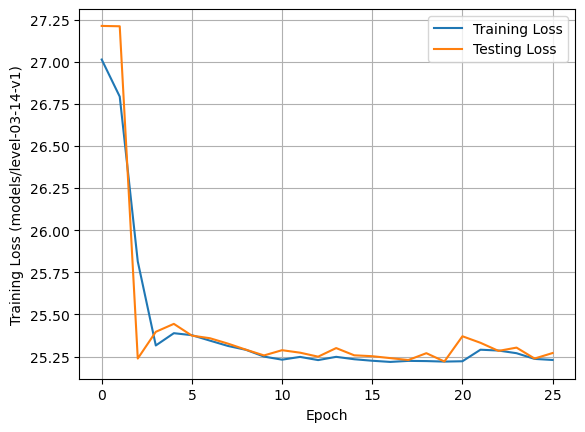

In [63]:
losses = pd.read_csv(os.path.join(path, 'losses.csv'))
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({os.path.dirname(config["job"]["LTuneTrain"]["loss_fn_path"])})')
ax.set_title(f'{os.path.basename(path)}')
ax.grid()
_ = ax.legend()

# Evaluation

In [64]:
def model_out_to_design(output):
    h = output[:, 0].item()
    size_ratio = torch.argmax(output[:, 1:]).item()
    return np.array([h, size_ratio + config['lsm']['size_ratio']['min']])

In [65]:
def eval_rand_workloads():
    WORKLOADS = 5000
    df = []
    workloads = data_generator.generate_workloads(WORKLOADS)
    for wl in tqdm(workloads):
        wl = np.array(wl)
        z0, z1, q, w = wl
        
        # eval normal
        stune_h, stune_T = solver.find_nominal_design(z0, z1, q, w).x
        stune_T = np.ceil(stune_T)
        stune_h = np.around(stune_h, 3)
        stune_pred = torch.Tensor([stune_h, stune_T - 2]).view(1, -1)
        stune_loss = cost_func_learned_raw_eval([stune_h, stune_T], wl)
        stune_cost = cf(stune_h, stune_T, z0, z1, q, w)
        stune_level = cf.cf.L(stune_h, stune_T, True)
        
        # eval learned
        x = torch.Tensor((z0, z1, q, w)).view(1, -1)
        ltune_h, ltune_T = model_out_to_design(model(x, hard=True))
        ltune_pred = torch.Tensor([ltune_h, ltune_T - 2]).view(1, -1)
        ltune_loss = cost_func_learned_raw_eval([ltune_h, ltune_T], wl)
        ltune_cost = cf(ltune_h, ltune_T, z0, z1, q, w)
        ltune_level = cf.cf.L(ltune_h, ltune_T, True)
        
        row = {
            'z0': z0,
            'z1': z1,
            'q': q,
            'w': w,
            'stune_h': stune_h,
            'stune_T': stune_T,
            'stune_cost': stune_cost,
            'stune_loss': stune_loss,
            'stune_level': stune_level,
            'ltune_h': ltune_h,
            'ltune_T': ltune_T,
            'ltune_cost': ltune_cost,
            'ltune_loss': ltune_loss,
            'ltune_level': ltune_level,
        }
        df.append(row)
    
    return pd.DataFrame(df)

In [66]:
np.random.seed(0)
df = eval_rand_workloads()
df['delta_cost'] = (df['stune_cost'] - df['ltune_cost']) / df['stune_cost']
df['delta_loss'] = (df['stune_loss'] - df['ltune_loss']) / df['stune_loss']
df['stune_diff'] = (df['stune_cost'] - df['stune_loss'])
df['ltune_diff'] = (df['ltune_cost'] - df['ltune_loss'])

  0%|          | 0/5000 [00:00<?, ?it/s]

In [74]:
df.sort_values(by='delta_cost', ascending=True).head(20)

,z0,z1,q,w,stune_h,stune_T,stune_cost,stune_loss,stune_level,ltune_h,ltune_T,ltune_cost,ltune_loss,ltune_level,delta_cost,delta_loss,stune_diff,ltune_diff
3061,0.536,0.003,0.452,0.009,4.833,50.0,1.237456,2.030163,2.0,3.672332,2.0,5.203711,5.105807,11.0,-3.205170,-1.514974,-0.792707,0.097904
496,0.354,0.020,0.004,0.622,3.934,3.0,3.249187,3.254566,7.0,0.896208,48.0,13.400824,13.505301,2.0,-3.124363,-3.149647,-0.005380,-0.104476
4672,0.410,0.002,0.018,0.570,4.173,3.0,3.089664,3.138063,7.0,1.234864,49.0,12.562961,12.613678,2.0,-3.066126,-3.019575,-0.048399,-0.050717
3397,0.336,0.034,0.005,0.625,3.856,3.0,3.278728,3.279506,7.0,0.786883,47.0,13.254142,13.347481,2.0,-3.042464,-3.069966,-0.000778,-0.093339
3841,0.431,0.066,0.013,0.490,4.548,3.0,2.733671,2.762201,7.0,1.423148,49.0,10.918513,10.917486,2.0,-2.994084,-2.952459,-0.028529,0.001027
1156,0.458,0.007,0.029,0.506,4.433,4.0,2.944980,2.908511,6.0,1.439079,49.0,11.252812,11.269912,2.0,-2.821014,-2.874805,0.036470,-0.017100
906,0.233,0.249,0.007,0.511,3.901,3.0,2.927243,2.963219,7.0,0.562334,48.0,11.183848,11.147065,2.0,-2.820608,-2.761809,-0.035976,0.036783
4941,0.530,0.034,0.002,0.434,5.083,3.0,2.367699,2.430375,7.0,2.138152,44.0,9.018046,9.053883,2.0,-2.808781,-2.725303,-0.062676,-0.035837
1843,0.535,0.077,0.020,0.368,5.182,4.0,2.260676,2.284515,6.0,2.500189,50.0,8.523517,3.197119,2.0,-2.770340,-0.399473,-0.023839,5.326399
1236,0.533,0.087,0.021,0.359,5.205,4.0,2.228246,2.254305,6.0,2.522750,50.0,8.335294,3.151903,2.0,-2.740743,-0.398171,-0.026059,5.183391


## Analytical Cost Model

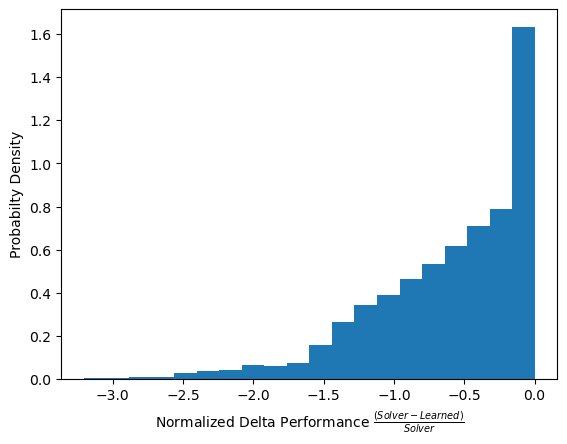

In [68]:
fig, ax = plt.subplots()
ax.hist(df['delta_cost'], bins=20, density=True)
ax.set_ylabel('Probabilty Density')
ax.set_xlabel('Normalized Delta Performance $\\frac{(Solver - Learned)}{Solver}$')
plt.show()

## Learned Cost Model

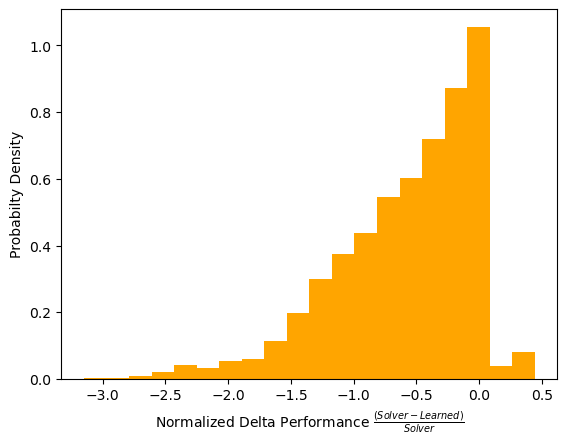

In [69]:
fig, ax = plt.subplots()
ax.hist(df['delta_loss'], bins=20, density=True, color='orange')
ax.set_ylabel('Probabilty Density')
ax.set_xlabel('Normalized Delta Performance $\\frac{(Solver - Learned)}{Solver}$')
plt.show()

## Difference in ACM and LCM

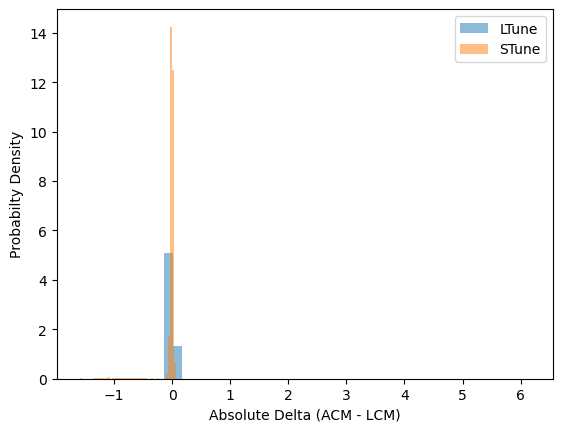

In [70]:
fig, ax = plt.subplots()
ax.hist(df['ltune_diff'], bins=50, alpha=0.5, density=True, label='LTune')
ax.hist(df['stune_diff'], bins=50, alpha=0.5, density=True, label='STune')
ax.set_ylabel('Probabilty Density')
ax.set_xlabel('Absolute Delta (ACM - LCM)')
ax.legend()
plt.show()

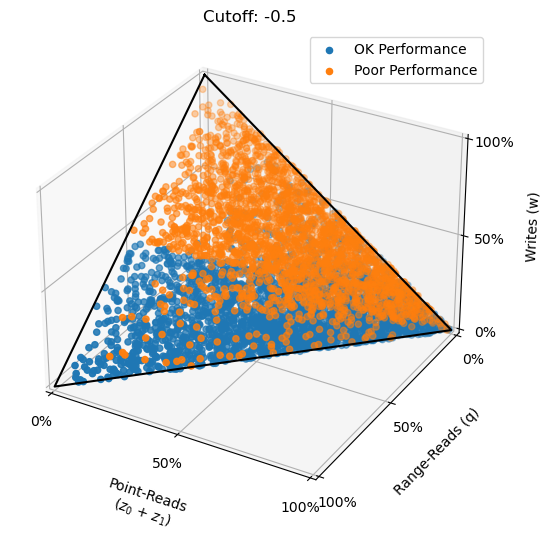

In [73]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
ax.set_ylabel('Range-Reads (q)', labelpad=10)
ax.set_zlabel('Writes (w)', labelpad=10)

cutoff = (-0.5)
groupa = df[df['delta_loss'] > cutoff]
groupb = df[df['delta_loss'] < cutoff]

ax.scatter(groupa['z0'] + groupa['z1'], groupa['q'], groupa['w'], label='OK Performance')
ax.scatter(groupb['z0'] + groupb['z1'], groupb['q'], groupb['w'], label='Poor Performance')
ax.legend()
ax.set_title(f'Cutoff: {cutoff}')
plt.show()